# Models Random Forest with GPU Rapids 

## Classification RF index GINI

In [1]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.svm import SVC

from bayes_opt import BayesianOptimization
from bayes_opt.util import Colours
import timeit

In [3]:
def get_data():
    """Synthetic binary classification dataset."""
    data, targets = make_classification(
        n_samples=1000,
        n_features=45,
        n_informative=12,
        n_redundant=100,
        random_state=134985745,
    )
    return data, targets


def svc_cv(C, gamma, data, targets):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    estimator = SVC(C=C, gamma=gamma, random_state=2)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=4)
    return cval.mean()


def rfc_cv(n_estimators, min_samples_split, max_features, data, targets):
    """Random Forest cross validation.
    This function will instantiate a random forest classifier with parameters
    n_estimators, min_samples_split, and max_features. Combined with data and
    targets this will in turn be used to perform cross validation. The result
    of cross validation is returned.
    Our goal is to find combinations of n_estimators, min_samples_split, and
    max_features that minimzes the log loss.
    """
    estimator = RFC(
        n_estimators=n_estimators,
        min_samples_split=min_samples_split,
        max_features=max_features,
        random_state=2
    )
    cval = cross_val_score(estimator, data, targets,
                           scoring='neg_log_loss', cv=4)
    return cval.mean()


def optimize_rfc(data, targets):
    """Optimization to Random Forest parameters."""
    def rfc_crossval(n_estimators, min_samples_split, max_features):
        """Wrapper of RandomForest cross validation.
        Notice how we ensure n_estimators and min_samples_split are casted
        to integer before we pass them along. Moreover, to avoid max_features
        taking values outside the (0, 1) range, we also ensure it is capped
        accordingly.
        """
        return rfc_cv(
            n_estimators=int(n_estimators),
            min_samples_split=int(min_samples_split),
            max_features=max(min(max_features, 0.999), 1e-3),
            data=data,
            targets=targets,
        )

    optimizer = BayesianOptimization(
        f=rfc_crossval,
        pbounds={
            "n_estimators": (10, 250),
            "min_samples_split": (2, 25),
            "max_features": (0.1, 0.999),
        },
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=10)

    print("Final result:", optimizer.max)

In [ ]:
# %%timeit
data, targets = get_data()

In [25]:
%%timeit
print(Colours.green("---Random Forest Classifier---"))
optimize_rfc(data, targets)

---Random Forest Classifier---
|   iter    |  target   | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------
|  1        | -0.3777   |  0.2722   |  16.31    |  115.1    |
|  2        | -0.3648   |  0.806    |  19.94    |  75.42    |
|  3        | -0.3774   |  0.3485   |  20.44    |  240.0    |
|  4        | -0.3557   |  0.8875   |  10.23    |  130.2    |
|  5        | -0.3664   |  0.7144   |  18.39    |  98.86    |
|  6        | -0.6459   |  0.999    |  2.0      |  10.0     |
|  7        | -0.3528   |  0.5371   |  8.287    |  127.9    |
|  8        | -0.3529   |  0.5253   |  2.09     |  249.2    |
|  9        | -0.3541   |  0.5048   |  2.02     |  198.8    |
|  10       | -0.3543   |  0.8738   |  2.05     |  82.07    |
|  11       | -0.3547   |  0.9692   |  2.023    |  159.8    |
|  12       | -0.3514   |  0.9986   |  2.337    |  225.9    |
|  13       | -0.3501   |  0.8352   |  2.082    |  114.9    |
|  14       | -0.3727   |  0.9774   |  

|  4        | -0.3557   |  0.8875   |  10.23    |  130.2    |
|  5        | -0.3664   |  0.7144   |  18.39    |  98.86    |
|  6        | -0.6459   |  0.999    |  2.0      |  10.0     |
|  7        | -0.3528   |  0.5371   |  8.287    |  127.9    |
|  8        | -0.3529   |  0.5253   |  2.09     |  249.2    |
|  9        | -0.3541   |  0.5048   |  2.02     |  198.8    |
|  10       | -0.3543   |  0.8738   |  2.05     |  82.07    |
|  11       | -0.3547   |  0.9692   |  2.023    |  159.8    |
|  12       | -0.3514   |  0.9986   |  2.337    |  225.9    |
|  13       | -0.3501   |  0.8352   |  2.082    |  114.9    |
|  14       | -0.3727   |  0.9774   |  24.85    |  189.1    |
|  15       | -0.3613   |  0.3327   |  2.035    |  139.0    |
Final result: {'target': -0.35006544307784926, 'params': {'max_features': 0.8352106850024508, 'min_samples_split': 2.0816226012494425, 'n_estimators': 114.9353627759933}}
---Random Forest Classifier---
|   iter    |  target   | max_fe... | min_sa... | n_es

## Rapids XGBoost Classifier Random Forest

In [49]:
#librarys rapids
import cudf 
import cuml
import cugraph

# load libraries required
import csv
import sys
import time
import os.path
import pandas
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    from urllib import urlretrieve

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [163]:
csv_filename = pd.read_csv('C:/Users/User/Desktop/databases.csv',nrows=105000,dtype=np.float32)
csv_filename = cudf.DataFrame.from_pandas(csv_filename)

In [72]:
# csv_filename.to_csv("C:/Users/User/Desktop/databases.csv", index=False, encoding='utf-8-sig')

In [164]:
csv_filename

,clase,lepton_pt,lepton_eta,lepton_phi,majnitud_faltante,falta_enjphi,jet_1_pt,jet_1_eta,jet_1_phi,jet_b_taj,jet_2_pt,jet_2_eta,jet_2_phi,jet2_b_tag,jet_3_pt,jet_3_eta,jet_3_phi,jet3_b_tag,jet_4_pt,jet_4_eta,jet_4_phi,jet4_b_tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,0.812581,-0.213642,1.271015,2.214872,0.499994,-1.261432,0.732156,0.000000,0.398701,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
1,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,0.851737,1.540659,-0.819690,2.214872,0.993490,0.356080,-0.208778,2.548224,1.256955,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
2,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,2.423265,-0.676016,0.736159,2.214872,1.298720,-1.430738,-0.364658,0.000000,0.745313,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
3,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,0.800872,1.020974,0.971407,2.214872,0.596761,-0.350273,0.631194,0.000000,0.479999,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.0,1.595839,-0.607811,0.007075,1.818450,-0.111906,0.847550,-0.566437,1.581239,2.173076,0.755421,0.643110,1.426367,0.000000,0.921661,-1.190432,-1.615589,0.000000,0.651114,-0.654227,-1.274345,3.101961,0.823761,0.938191,0.971758,0.789176,0.430553,0.961357,0.957818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104995,1.0,0.936275,-0.596123,1.092939,0.209441,0.851330,0.923218,-0.102019,-0.077000,0.000000,0.805279,-0.381690,1.561745,0.000000,0.898479,0.269607,-0.982636,2.548224,0.608031,-0.958207,-0.547407,1.550981,1.842267,1.077933,0.998489,0.775795,0.494956,0.741864,0.715021
104996,1.0,2.168475,1.084947,0.651269,0.329490,0.369534,0.620272,0.182177,-1.566055,2.173076,0.715635,0.113711,-1.038847,0.000000,0.426760,-1.171317,-0.985965,0.000000,0.747017,0.623324,-0.563503,3.101961,0.837281,0.739536,0.980731,0.732594,0.602512,0.762342,0.710487
104997,0.0,0.684637,0.498618,1.562351,0.512479,0.277104,1.115776,0.001955,-0.945709,2.173076,0.983306,-1.614363,0.769448,0.000000,0.668942,-1.914080,1.261928,0.000000,0.414522,-1.568667,0.225133,0.000000,0.601625,0.824539,0.988517,1.132267,0.719711,1.136996,1.244757
104998,1.0,0.737893,-1.227255,0.939242,0.885532,1.500681,0.822541,-0.362450,-0.731166,2.173076,0.494675,-0.705157,1.594480,0.000000,0.576389,1.100664,-0.134998,2.548224,0.461500,0.243557,0.517017,0.000000,0.611030,0.791053,0.984799,0.918166,0.867012,0.829836,0.677482


In [338]:
# load data
X = csv_filename.iloc[:,1:]
Y = csv_filename.iloc[:,0]

# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.11, random_state=7)

# fit model no training data
model = XGBClassifier()
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)

# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 70.87%


In [339]:
pd.DataFrame(predictions).reset_index().groupby(0).count()

,index
0,
0.0,5288
1.0,6262


In [340]:
from sklearn.metrics import confusion_matrix
from termcolor import colored
# y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, (y_pred>0.5))
print(colored('The Confusion Matrix is: ', 'red'),'\n', cm)
predict_accuracy_on_test_set = (cm[0,0] + cm[1,1])/(cm[0,0] + cm[1,1]+cm[1,0] + cm[0,1])
print(colored('The Accuracy on Test Set is: ', 'blue'), colored(predict_accuracy_on_test_set, 'blue'))

The Confusion Matrix is:  
 [[3719 1795]
 [1569 4467]]
The Accuracy on Test Set is:  0.7087445887445888


In [337]:
score = model.score(X_train, y_train)  
print("Training score: ", score)

Training score:  0.7173650793650793


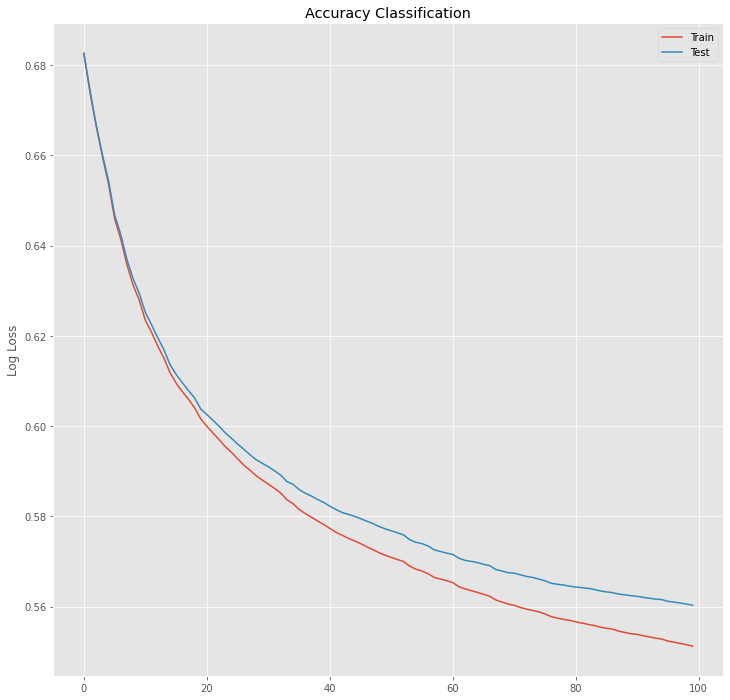

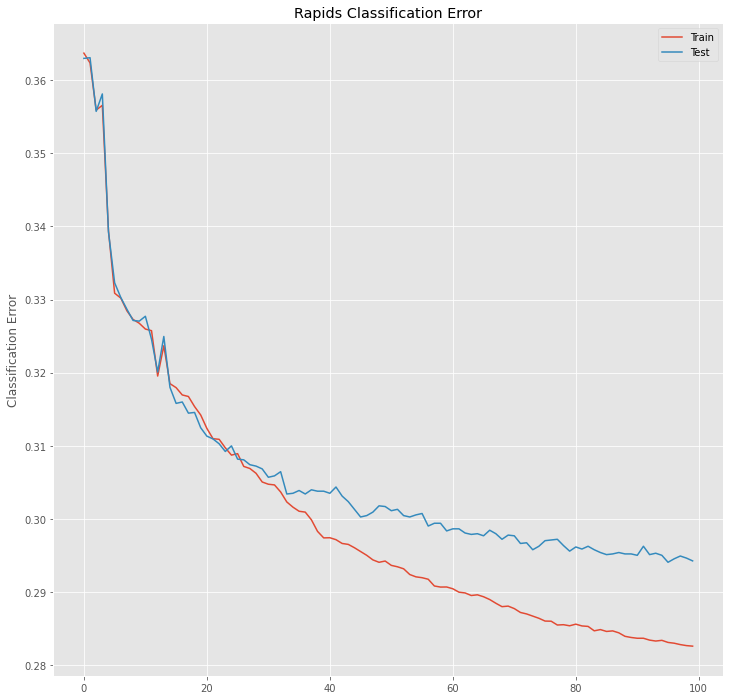

In [303]:
# retrieve performance metrics
results = model.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot log loss
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
ax.legend()
pyplot.ylabel('Log Loss')
pyplot.title('Accuracy Classification')
pyplot.show()

# plot classification error
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Classification Error')
pyplot.title('Rapids Classification Error')
pyplot.show()

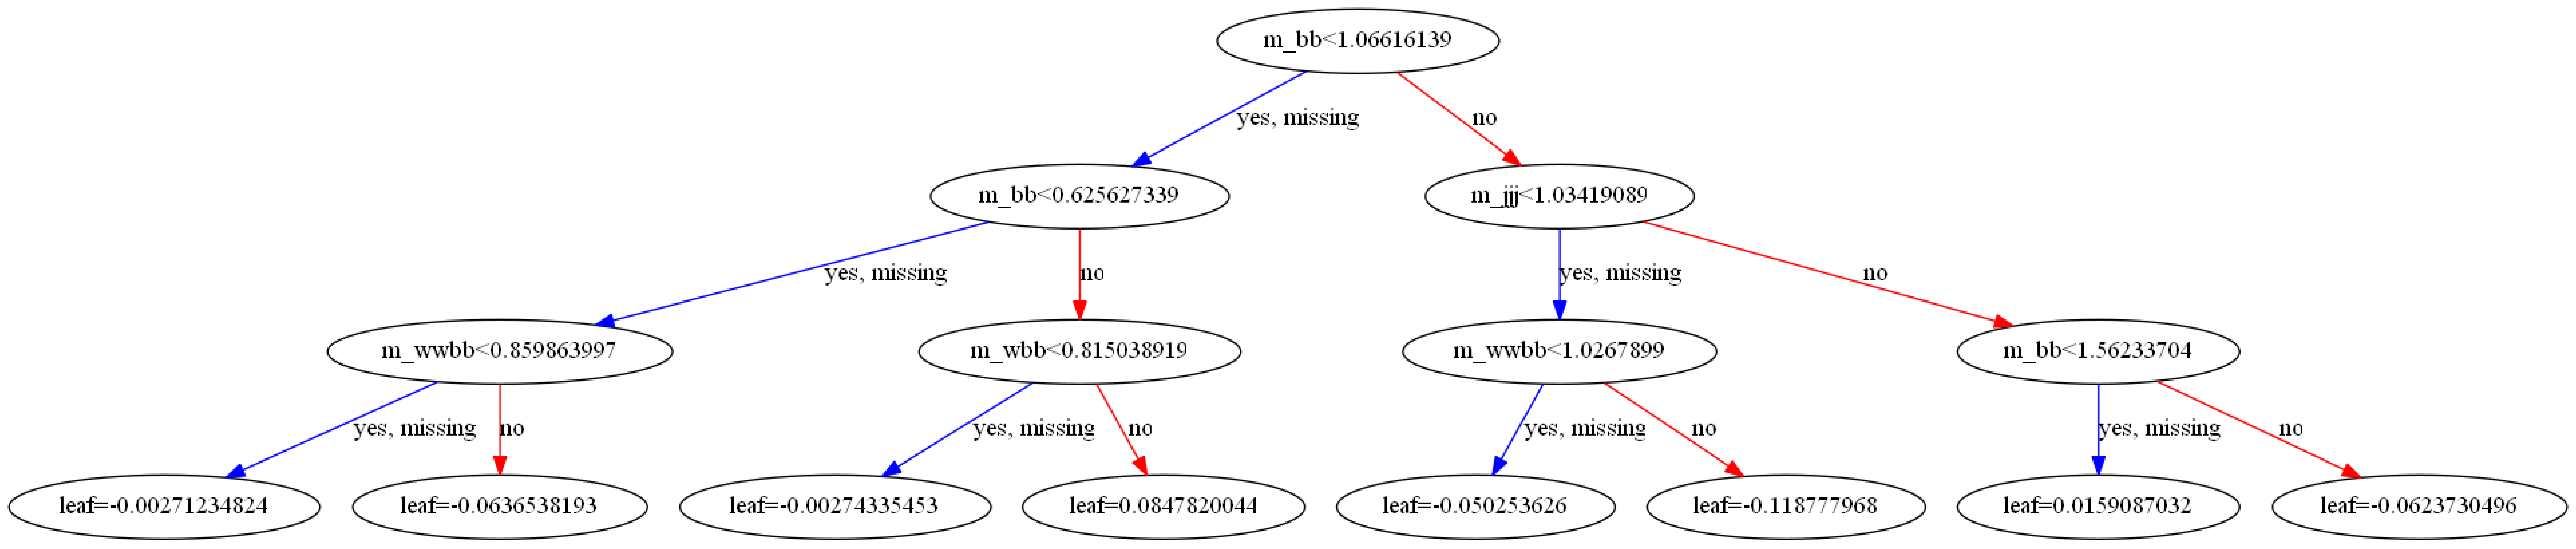

In [240]:
xgb.plot_tree(model)
plt.rcParams['figure.figsize'] = [150, 100]
plt.show()

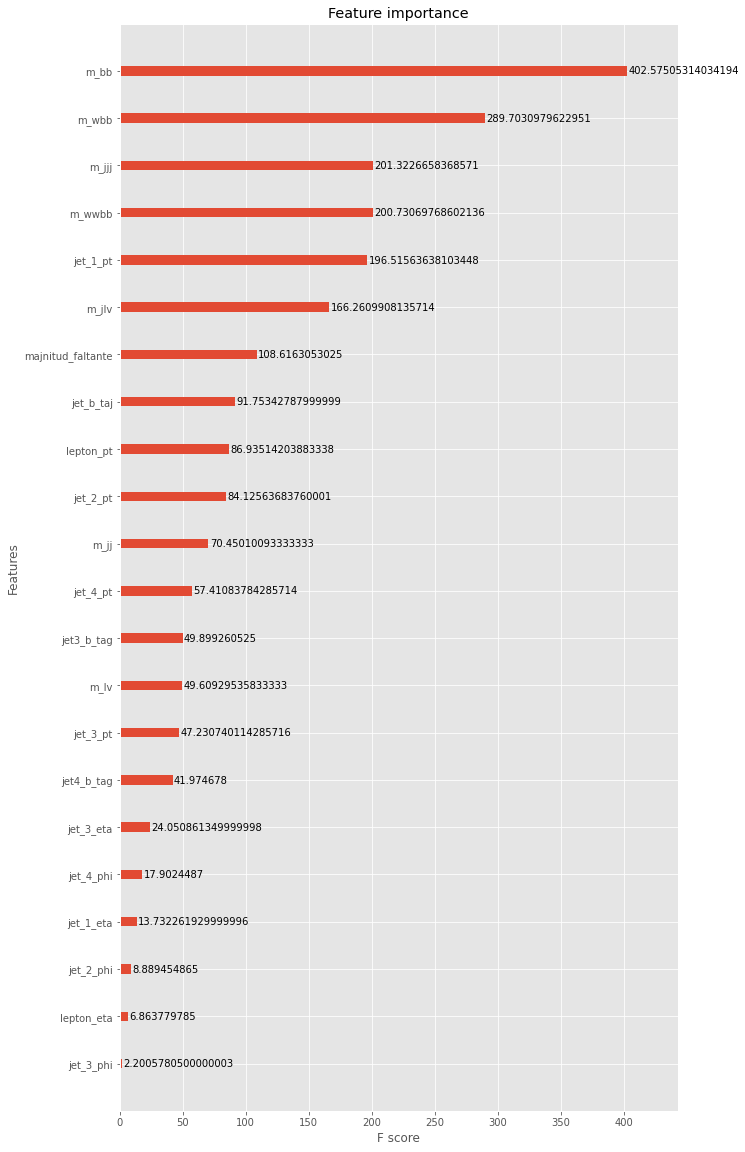

In [168]:
xgb.plot_importance(model,importance_type='gain')
plt.rcParams['figure.figsize'] = [10,20]
plt.show()

# Regression of RFC 

In [206]:
#librarys rapids
import cudf 
import cuml
import cugraph

# load libraries required
import csv
import sys
import time
import os.path
import pandas
import numpy as np
import pandas as pd
import xgboost as xgb
from matplotlib import pyplot
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
if sys.version_info[0] >= 3:
    from urllib.request import urlretrieve
else:
    from urllib import urlretrieve

from sklearn.datasets import load_boston
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold

In [207]:
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0.0,0.573,6.593,69.1,2.4786,1.0,273.0,21.0,391.99,9.67,22.4
502,0.04527,0.0,11.93,0.0,0.573,6.120,76.7,2.2875,1.0,273.0,21.0,396.90,9.08,20.6
503,0.06076,0.0,11.93,0.0,0.573,6.976,91.0,2.1675,1.0,273.0,21.0,396.90,5.64,23.9
504,0.10959,0.0,11.93,0.0,0.573,6.794,89.3,2.3889,1.0,273.0,21.0,393.45,6.48,22.0


In [208]:
boston = load_boston() #load dataset
data = pd.DataFrame(boston.data) # data frame dataset
data.columns = boston.feature_names #index columns data 
data['PRICE'] = boston.target # target columns in data 

X, y = data.iloc[:,:-1],data.iloc[:,-1] # definition matrix x and y 
data_dmatrix = xgb.DMatrix(data=X,label=y) # declaration d.matrix 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123) #matrix train and test 

xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10) #model Regression for RF 


xg_reg.fit(X_train,y_train) #fit model RFCRegressor 
preds = xg_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds)) #squared error of RFC Regressor  
print("RMSE: %f" % (rmse))

[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE: 10.449300


In [209]:
params = {"objective":"reg:linear",'colsample_bytree': 0.3,'learning_rate': 0.1,
                'max_depth': 5, 'alpha': 10}

cv_results = xgb.cv(dtrain=data_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=123)

cv_results.head()

[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,21.679234,0.025626,21.677613,0.050617
1,19.772293,0.016054,19.773320,0.020571
2,18.049563,0.058904,18.065856,0.082746
3,16.430113,0.013615,16.492199,0.020919
4,15.025977,0.062132,15.132644,0.073104


In [210]:
print((cv_results["test-rmse-mean"]).tail(1))

49    3.975679
Name: test-rmse-mean, dtype: float64


In [211]:
xg_reg = xgb.train(params=params, dtrain=data_dmatrix, num_boost_round=10)

[00:14:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


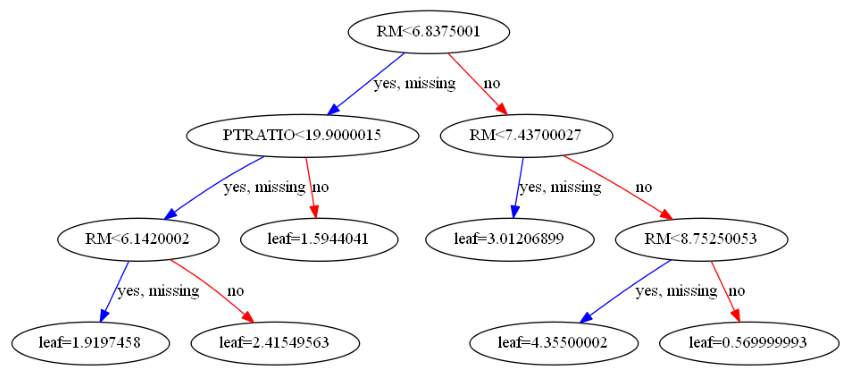

In [212]:
xgb.plot_tree(xg_reg,num_trees=0)
plt.rcParams['figure.figsize'] = [50, 50]
plt.show()

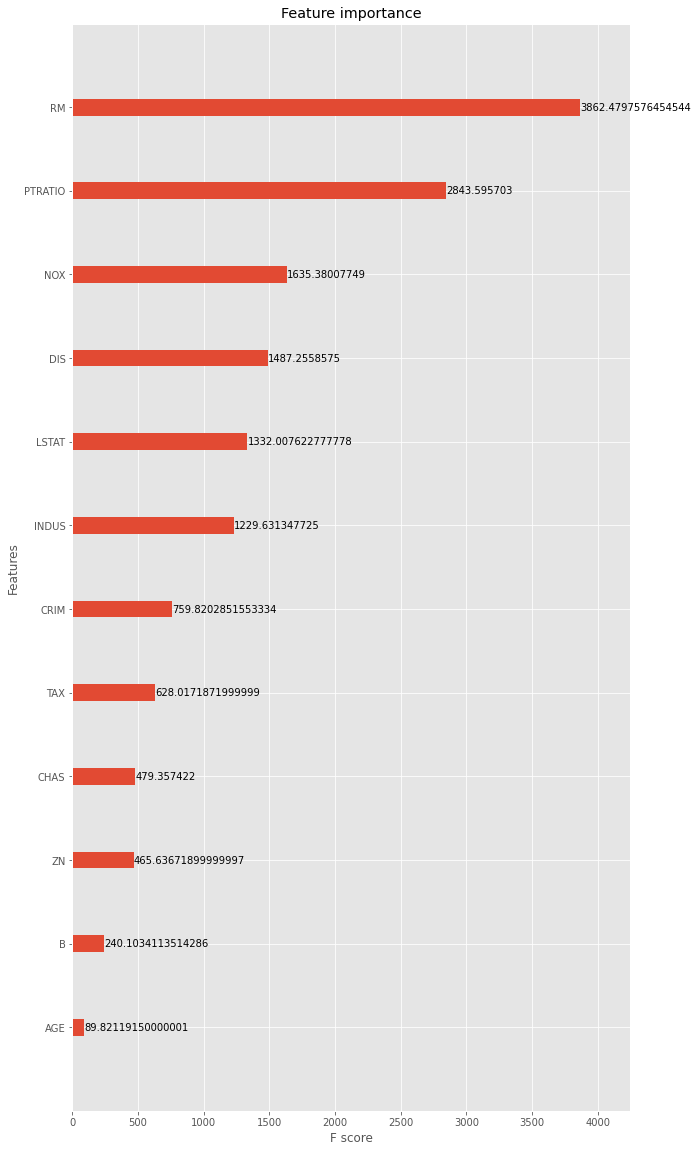

In [149]:
xgb.plot_importance(xg_reg,importance_type='gain')
plt.rcParams['figure.figsize'] = [10,20]
plt.show()

In [184]:
boston = load_boston()
x, y = boston.data, boston.target
xtrain, xtest, ytrain, ytest=train_test_split(x, y, test_size=0.10)

xgbr = xgb.XGBRegressor(verbosity=0) 

In [185]:
xgbr.fit(xtrain, ytrain)

score = xgbr.score(xtrain, ytrain)  
print("Training score: ", score)

Training score:  0.9717794990903753


In [186]:
scores = cross_val_score(xgbr, xtrain, ytrain,cv=10)
print(scores)
print("Mean cross-validation score: %.2f" % scores.mean())

[0.89613924 0.70556103 0.92108741 0.82274755 0.95552503 0.90357393
 0.88796216 0.89610322 0.8458877  0.94367719]
Mean cross-validation score: 0.88


In [187]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(xgbr, xtrain, ytrain, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

K-fold CV average score: 0.86


In [188]:
ypred = xgbr.predict(xtest)
mse = mean_squared_error(ytest, ypred)
print("MSE: %.2f" % mse)
print("RMSE: %.2f" % (mse*(1/2.0)))

MSE: 7.30
RMSE: 3.65


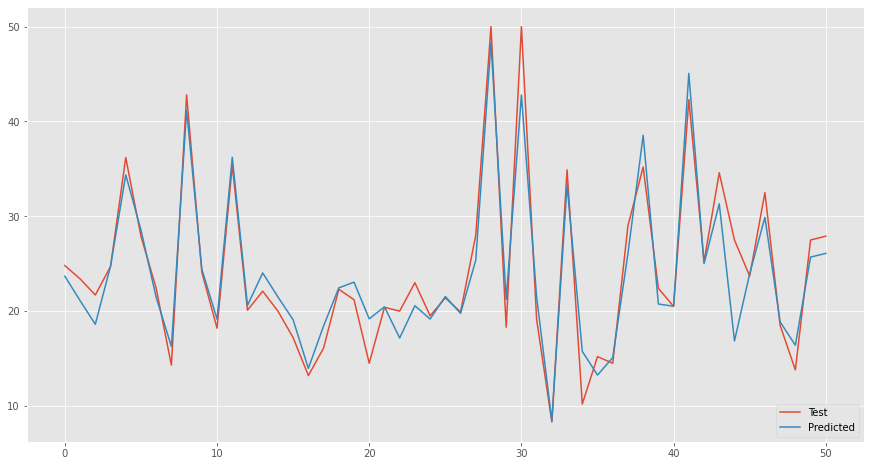

In [204]:
# %matplotlib inline
x_ax = range(len(ytest))
plt.plot(x_ax, ytest, label="Test")
plt.plot(x_ax, ypred, label="Predicted")
plt.legend(loc='lower right')
plt.rcParams['figure.figsize'] = [15,8]
plt.show()

[21:25:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Accuracy: 67.09%


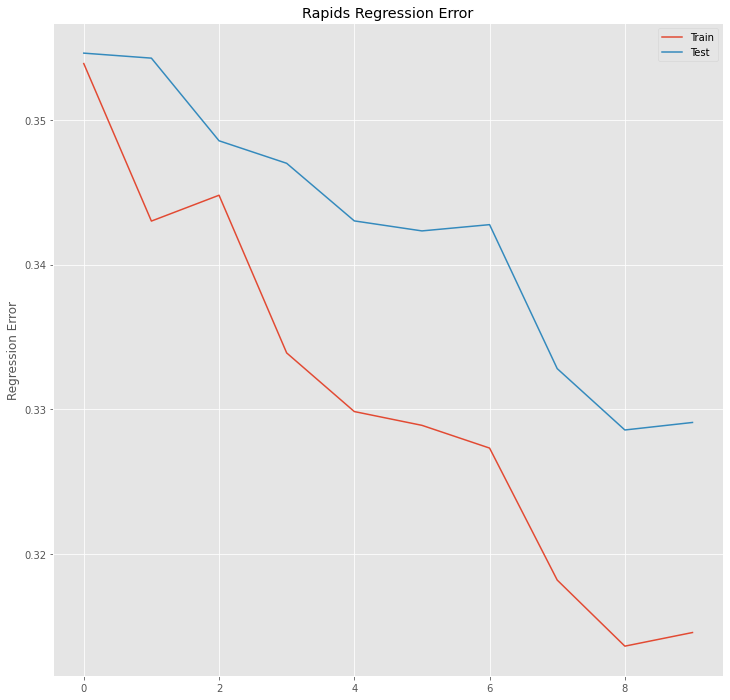

In [219]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)

eval_set = [(X_train, y_train), (X_test, y_test)]
xg_reg.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=False)


# make predictions for test data
preds = xg_reg.predict(X_test)
predictions = [round(value) for value in preds]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

# retrieve performance metrics
results = xg_reg.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)

# plot classification error
fig, ax = pyplot.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
pyplot.ylabel('Regression Error')
pyplot.title('Rapids Regression Error')
pyplot.show()